# Fundamentos de ETL com Python

Para esse projeto foi utilizado uma base de dados do CENIPA.

A base de dados de ocorrências aeronáuticas é gerenciada pelo **Centro de Investigação e Prevenção de Acidentes Aeronáuticos (CENIPA)**. Constam nesta base de dados as ocorrências aeronáuticas notificadas ao CENIPA nos últimos 10 anos e que ocorreram em solo brasileiro.

Dentre as informações disponíveis estão os dados sobre as aeronaves envolvidas, fatalidades, local, data, horário dos eventos e informações taxonômicas típicas das investigações de acidentes (AIG). São resguardadas a privacidade de pessoas físicas/jurídicas envolvidas conforme previsto pela Lei de Acesso à Informação (Lei n° 12.527, de 18 de novembro de 2011).

Essa base de dados é composta por informações preliminares provenientes do formulário CENIPA-05 (Ficha de Notificação de Ocorrências Aeronáuticas) e consolidada a partir dos relatórios de investigações publicados. Outra forma de visualização desses dados é pelo Painel SIPAER disponível na página do CENIPA.

https://dados.gov.br/dataset/ocorrencias-aeronauticas-da-aviacao-civil-brasileira





## Extração

A extração da base utilizada foi feita por meio do site do CENIPA, diponível no link a baixo:
* https://dados.gov.br/dataset/ocorrencias-aeronauticas-da-aviacao-civil-brasileira

Na secção de Dados e Recursos a Tabela ocorrências pode ser baixada, assim como outras tabelas


### Bibliotecas

Para quem ainda não possuir o pandera instalado é só utilizar o comando: **pip install pandera**

O pandera fornece uma API flexível e expressiva para realizar a validação de dados em dados organizados (longos) e amplos para tornar os pipelines de processamento de dados mais legíveis e robustos.

In [1]:
#Bibliotecas
import pandas as pd
import pandera as pa
import matplotlib.pyplot as plt

Antes do carregamento do arquivo algumas colunas foram previamente excluidas em um editor de planilhas.
* codigo_ocorrencia1;
* codigo_ocorrencia3;
* codigo_ocorrencia4;
* ocorrencia_latitude;
* ocorrencia_longitude;
* ocorrencia_pais;
* investigacao_aeronave_liberada;
* investigacao_status;
* divulgacao_relatorio_numero;
* divulgacao_relatorio_publicado;
* divulgacao_dia_publicacao;
* total_aeronaves_envolvidas;
* ocorrencia_saida_pista;

Essas colunas poderiam ter sidos carregadas no dataframe e depois exluidas por meio de código:

```
colunas_remove = ['codigo_ocorrencia1',
                    'codigo_ocorrencia3',
                    'codigo_ocorrencia4',
                    'ocorrencia_latitude',
                    'ocorrencia_longitude',
                    'ocorrencia_pais',
                    'investigacao_aeronave_liberada',
                    'investigacao_status',
                    'divulgacao_relatorio_numero',
                    'divulgacao_relatorio_publicado',
                    'divulgacao_dia_publicacao',
                    'total_aeronaves_envolvidas',
                    'ocorrencia_saida_pista']
                    
df = df.drop(columns=colunas_remove, inplace=True)
```

**Observações:**

* **parse_dates:** permite passar uma lista de colunas que devem ser intepretadas como data - o arquivo veio a data como tipo object. Se alguma data estiver com formato incorreto, o parse não vai conseguir transformar a coluna em DateTime e ela continuará como object. Para evitar que esse tipo de erro possa passar na etapa de validação do dados, foi utilizada a criação de um esquema de validação das colunas com o pandera.


* **dayfirts** -> o primeiro valor da data é o dia -> o aquivo veio com o dia no lugar do mês.


* **NaT** -> quando a data não existe no arquivo -> vazio. É como se fosse o NaN porém só aparece em datas.

In [2]:
#carregamento do arquivo csv
df = pd.read_csv('ocorrencia_2010_2020 - ocorrencia_2010_2020.csv', parse_dates=['ocorrencia_dia'], dayfirst=True)

Se já for de conhecimento quais são os valores considerados ausentes é possível fazer a substituição desses valores diretamente no read_csv, utilizando o parâmetro **na_values** passando uma lista com os valores ausentes.

Para esse conjunto de dados se a linha a baixo for executada será necessario fazer modificações na etapa de validação.

In [3]:
#valores_ausentes = ['**','****', '*****', '###!', '####', 'NULL']
#df = pd.read_csv('ocorrencia_2010_2020 - ocorrencia_2010_2020.csv', parse_dates=['ocorrencia_dia'], dayfirst=True, na_values=valores_ausentes)

In [4]:
df.head(10)

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes
0,40211,40211,INCIDENTE,RIO DE JANEIRO,RJ,****,2010-01-03,12:00:00,0
1,40349,40349,INCIDENTE,BELÉM,PA,SBBE,2010-01-03,11:05:00,0
2,40351,40351,INCIDENTE,RIO DE JANEIRO,RJ,SBRJ,2010-01-03,03:00:00,0
3,39527,39527,ACIDENTE,LUCAS DO RIO VERDE,MT,****,2010-01-04,17:30:00,0
4,40324,40324,INCIDENTE,PELOTAS,RS,SBPK,2010-01-05,19:25:00,0
5,39807,39807,INCIDENTE,SALVADOR,BA,****,2010-01-06,17:53:00,0
6,40215,40215,INCIDENTE,COARI,AM,SBUY,2010-01-07,18:40:00,0
7,39707,39707,INCIDENTE GRAVE,CANUTAMA,AM,****,2010-01-09,12:30:00,3
8,39156,39156,INCIDENTE GRAVE,CASCAVEL,PR,SBCA,2010-01-10,23:15:00,2
9,39711,39711,INCIDENTE GRAVE,PARÁ DE MINAS,MG,****,2010-01-10,20:00:00,0


## Montando um schema de validação com o pandera

Validação de todas as colunas
* **Exemplo:** Validando se a coluna codigo_ocorrencia tem valores inteiros

Foi colocado uma restrição na coluna ocorrencia_hora, utilizando uma expressão regular, para estabelecer um formato de 24 horas.

Foi validado o tamanho da string na coluna ocorrencia_uf - Tamanho mínimo 2 e máximo 2 caracteres.

Se acontecer de um coluna as vezes vir outras não, é possível passar o parâmetro required=False
* **Exemplo:** A coluna codigo pode vir ou não no df, por isso foi passado o parâmetro required = False, o padrão é True.
 ```
 "codigo":pa.Column(pa.Int, required=False)
 
 ```
 

In [5]:
schema = pa.DataFrameSchema(
    columns = {
        "codigo_ocorrencia":pa.Column(pa.Int),
        "codigo_ocorrencia2":pa.Column(pa.Int),
        "ocorrencia_classificacao":pa.Column(pa.String),
        "ocorrencia_cidade":pa.Column(pa.String),
        "ocorrencia_uf":pa.Column(pa.String, pa.Check.str_length(2,2)),
        "ocorrencia_aerodromo":pa.Column(pa.String),
        "ocorrencia_dia":pa.Column(pa.DateTime),
        "ocorrencia_hora":pa.Column(pa.String, pa.Check.str_matches(r'^([0-1]?[0-9]|[2][0-3]):([0-5][0-9])(:[0-5][0-9])?$'), nullable=True),
        "total_recomendacoes":pa.Column(pa.Int),
        
    }
)

In [6]:
# validação do df com base no schema acima
schema.validate(df)

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes
0,40211,40211,INCIDENTE,RIO DE JANEIRO,RJ,****,2010-01-03,12:00:00,0
1,40349,40349,INCIDENTE,BELÉM,PA,SBBE,2010-01-03,11:05:00,0
2,40351,40351,INCIDENTE,RIO DE JANEIRO,RJ,SBRJ,2010-01-03,03:00:00,0
3,39527,39527,ACIDENTE,LUCAS DO RIO VERDE,MT,****,2010-01-04,17:30:00,0
4,40324,40324,INCIDENTE,PELOTAS,RS,SBPK,2010-01-05,19:25:00,0
...,...,...,...,...,...,...,...,...,...
5747,79804,79804,INCIDENTE,CAMPINAS,SP,SBKP,2020-12-29,19:00:00,0
5748,79757,79757,INCIDENTE GRAVE,LAGOA DA CONFUSÃO,TO,****,2020-12-30,18:30:00,0
5749,79802,79802,INCIDENTE,RIO DE JANEIRO,RJ,SBGL,2020-12-30,00:54:00,0
5750,79756,79756,INCIDENTE GRAVE,VICENTINA,MS,****,2020-12-31,09:00:00,0


## Limpeza dos Dados

Dados faltantes em ocorrencia_aerodromo -> (********); (5*); (###!); (####)

Dados faltantes em ocorrencia_uf -> **

Dados faltantes em ocorrencia_hora -> NULL

In [7]:
#todos os valores únicos para a coluna ocorrencia_aerodromo
df['ocorrencia_aerodromo'].unique()

array(['****', 'SBBE', 'SBRJ', 'SBPK', 'SBUY', 'SBCA', 'SBMT', 'SBBR',
       'SNGU', 'SBGL', 'SBCZ', 'SBPF', 'SBBI', 'SBGR', 'SBPJ', 'SBJC',
       'SBFL', 'SNCL', 'SBGO', 'SNTY', 'SBSR', 'SBVT', 'SBPC', 'SBSV',
       'SBCT', 'SBCY', 'SWLC', 'SBJR', 'SBEG', 'SBPR', 'SBLO', 'SBRB',
       'SBSM', 'SSBL', 'SBMK', 'SBSP', 'SBCF', 'SBUL', 'SWUZ', 'SWNS',
       'SBFZ', 'SNVR', 'SBPN', 'SSUV', 'SBKP', 'SWNV', 'SBSJ', 'SBML',
       'SBPA', 'SBME', 'SDPY', 'SWOZ', 'SNEM', 'SBBH', 'SJCY', 'SBSL',
       'SBMA', 'SWKC', 'SBMO', 'SBJD', 'SDAM', 'SBCJ', 'SNUZ', 'SBPS',
       'SBJV', 'SNFX', 'SBPL', 'SWXV', 'SBAR', 'SBNF', 'SBRF', 'SSZW',
       'SWRD', 'SWLV', 'SSGP', 'SDOI', 'SBAE', 'SNDV', 'SSKS', 'SBMG',
       'SBQV', 'SBIP', 'SBAT', 'SWFR', 'SBBV', 'SBJP', 'SSVN', 'SSPS',
       'SDPW', 'SBSN', 'SNDT', 'SSKZ', 'SBUR', 'SBTE', '*****', 'SBBU',
       'SNXT', 'SBRP', 'SSCF', 'SSIE', 'SBCG', 'SBAQ', 'SBIZ', 'SBBP',
       'SSOG', 'SIXE', 'SNPC', '###!', 'SNWS', 'SNAU', 'SDLO', 'SNGG',
     

In [8]:
# Selecionando todas as linhas que possuem ocorrencia_aerodromo igual a **** ou igual a *****.
filtro = (df['ocorrencia_aerodromo'] == '****') | (df['ocorrencia_aerodromo'] == '*****')
df.loc[filtro] 

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes
0,40211,40211,INCIDENTE,RIO DE JANEIRO,RJ,****,2010-01-03,12:00:00,0
3,39527,39527,ACIDENTE,LUCAS DO RIO VERDE,MT,****,2010-01-04,17:30:00,0
5,39807,39807,INCIDENTE,SALVADOR,BA,****,2010-01-06,17:53:00,0
7,39707,39707,INCIDENTE GRAVE,CANUTAMA,AM,****,2010-01-09,12:30:00,3
9,39711,39711,INCIDENTE GRAVE,PARÁ DE MINAS,MG,****,2010-01-10,20:00:00,0
...,...,...,...,...,...,...,...,...,...
5741,79754,79754,INCIDENTE GRAVE,NOVA MARINGÁ,MT,****,2020-12-28,13:00:00,0
5744,79753,79753,INCIDENTE GRAVE,GOIATUBA,GO,****,2020-12-29,12:00:00,0
5745,79755,79755,ACIDENTE,MATO RICO,PR,****,2020-12-29,10:30:00,0
5748,79757,79757,INCIDENTE GRAVE,LAGOA DA CONFUSÃO,TO,****,2020-12-30,18:30:00,0


In [9]:
#Substituindo os valores por NA -> not available
df.replace(['**','****', '*****', '###!', '####', 'NULL'], pd.NA, inplace = True)

In [10]:
#Para saber a quantidade de valores nulos também poderiamos utilizar - df.isna().sum()
df.isnull().sum()

codigo_ocorrencia              0
codigo_ocorrencia2             0
ocorrencia_classificacao       0
ocorrencia_cidade              0
ocorrencia_uf                  1
ocorrencia_aerodromo        2349
ocorrencia_dia                 0
ocorrencia_hora                1
total_recomendacoes            0
dtype: int64

In [11]:
# Substituindo todos os valores nulos por 0
df.fillna(0)

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes
0,40211,40211,INCIDENTE,RIO DE JANEIRO,RJ,0,2010-01-03,12:00:00,0
1,40349,40349,INCIDENTE,BELÉM,PA,SBBE,2010-01-03,11:05:00,0
2,40351,40351,INCIDENTE,RIO DE JANEIRO,RJ,SBRJ,2010-01-03,03:00:00,0
3,39527,39527,ACIDENTE,LUCAS DO RIO VERDE,MT,0,2010-01-04,17:30:00,0
4,40324,40324,INCIDENTE,PELOTAS,RS,SBPK,2010-01-05,19:25:00,0
...,...,...,...,...,...,...,...,...,...
5747,79804,79804,INCIDENTE,CAMPINAS,SP,SBKP,2020-12-29,19:00:00,0
5748,79757,79757,INCIDENTE GRAVE,LAGOA DA CONFUSÃO,TO,0,2020-12-30,18:30:00,0
5749,79802,79802,INCIDENTE,RIO DE JANEIRO,RJ,SBGL,2020-12-30,00:54:00,0
5750,79756,79756,INCIDENTE GRAVE,VICENTINA,MS,0,2020-12-31,09:00:00,0


### Transformação e Agregação dos dados

Aplicações de filtros e agregações de dados para visualização dos dados

In [12]:
# definindo o estilo utilizado nos gráficos
plt.style.use('seaborn')

In [13]:
# Esses dados são de qual período?
print('Data mais recente: ',df['ocorrencia_dia'].max())
print('Data mais antiga: ',df['ocorrencia_dia'].min())

Data mais recente:  2020-12-31 00:00:00
Data mais antiga:  2010-01-03 00:00:00


**Esse conjunto de dados possui ocorrências de 03/01/2010 até 31/12/2020.**

Analisando a classificação das ocorrências

In [14]:
# Quantidade de cada uma das classificação no perído de 2010 a 2020
df['ocorrencia_classificacao'].value_counts()

INCIDENTE          3171
ACIDENTE           1844
INCIDENTE GRAVE     737
Name: ocorrencia_classificacao, dtype: int64

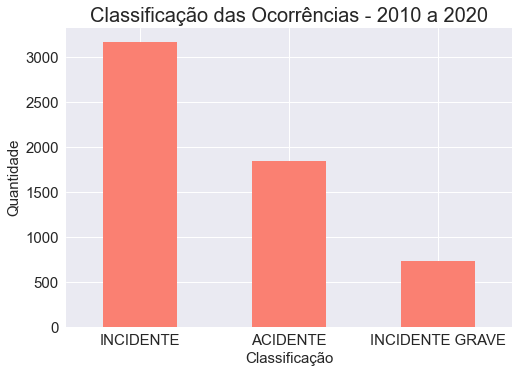

In [15]:
# Gráfico de barras
df['ocorrencia_classificacao'].value_counts().plot.bar(color='salmon', fontsize=15)
plt.title('Classificação das Ocorrências - 2010 a 2020', fontsize=20)
plt.xlabel('Classificação', fontsize=15)
plt.xticks(rotation='horizontal')
plt.ylabel('Quantidade', fontsize=15);

Como podemos observar nos resultados a cima, a maior parte das ocorrências são de INCIDENTE, seguindo de ACIDENTE e INCIDENTE GRAVE.

Vamos analisar agora a localização dessas classificações.

Para facilitar as análises criei 5 data frames que irão representar as regiões do Brasil.

In [16]:
# verificando quais Estados estão presentes no df
# lembrando que existe um valor de UF não informado - <NA>
df['ocorrencia_uf'].unique()

array(['RJ', 'PA', 'MT', 'RS', 'BA', 'AM', 'PR', 'MG', 'SP', 'DF', 'AC',
       'TO', 'SC', 'GO', 'MA', 'ES', 'PE', 'RR', 'MS', 'CE', 'AP', 'AL',
       'RO', 'SE', 'PB', 'PI', 'RN', <NA>], dtype=object)

In [17]:
# df com as ocorrências da região sudeste
filtro = df['ocorrencia_uf'].isin(['SP', 'MG', 'ES', 'RJ'])
df_sudeste = df.loc[filtro]

In [18]:
# df com as ocorrências da região nordeste
filtro = df['ocorrencia_uf'].isin(['MA', 'PI', 'BA', 'CE', 'PE', 'SE', 'AL', 'PB', 'RN'])
df_nordeste = df.loc[filtro]

In [19]:
# df com as ocorrências da região centro-oeste
filtro = df['ocorrencia_uf'].isin(['MS', 'MT', 'GO', 'DF'])
df_centro_oeste = df.loc[filtro]


In [20]:
# df com as ocorrências da região norte
filtro = df['ocorrencia_uf'].isin(['AC', 'RO', 'AM', 'RR', 'PA', 'TO', 'AP'])
df_norte = df.loc[filtro]

In [21]:
# df com as ocorrências da região sul
filtro = df['ocorrencia_uf'].isin(['RS', 'SC', 'PR'])
df_sul = df.loc[filtro]

In [22]:
# Número de registros/linhas de cada um dos novos df criados
print('Ocorrencias do sudeste:',df_sudeste['ocorrencia_classificacao'].count())
print('Ocorrencias do nordeste:',df_nordeste['ocorrencia_classificacao'].count())
print('Ocorrencias do centro-oeste:',df_centro_oeste['ocorrencia_classificacao'].count())
print('Ocorrencias do norte:',df_norte['ocorrencia_classificacao'].count())
print('Ocorrencias do sul:',df_sul['ocorrencia_classificacao'].count())

Ocorrencias do sudeste: 2493
Ocorrencias do nordeste: 608
Ocorrencias do centro-oeste: 887
Ocorrencias do norte: 737
Ocorrencias do sul: 1026


Agora vamos criar uma nova coluna chamada região para analisar os dados por regiões do Brasil

In [23]:
#Criando uma nova coluna, chamada regiao, no df e adicionado um valor vazio.
df['regiao'] = ''

In [24]:
# Vou precisar dos indexs das linhas de cada df que representa cada uma das 5 regiões, para inserir os valores corretos na coluna regiao
index_sul = df_sul.index
index_centro_oeste = df_centro_oeste.index
index_norte = df_norte.index
index_nordeste = df_nordeste.index
index_sudeste = df_sudeste.index

In [25]:
# Adicionando as regiões em cada linha com base nos index dos df que representam cada uma das regiões 
df.loc[index_sul, 'regiao'] = 'Sul'
df.loc[index_centro_oeste, 'regiao'] = 'Centro-Oeste'
df.loc[index_norte, 'regiao'] = 'Norte'
df.loc[index_nordeste, 'regiao'] = 'Nordeste'
df.loc[index_sudeste, 'regiao'] = 'Sudeste'

In [26]:
# Verificando se os valores foram inseridos
df.head(12)

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes,regiao
0,40211,40211,INCIDENTE,RIO DE JANEIRO,RJ,<NA>,2010-01-03,12:00:00,0,Sudeste
1,40349,40349,INCIDENTE,BELÉM,PA,SBBE,2010-01-03,11:05:00,0,Norte
2,40351,40351,INCIDENTE,RIO DE JANEIRO,RJ,SBRJ,2010-01-03,03:00:00,0,Sudeste
3,39527,39527,ACIDENTE,LUCAS DO RIO VERDE,MT,<NA>,2010-01-04,17:30:00,0,Centro-Oeste
4,40324,40324,INCIDENTE,PELOTAS,RS,SBPK,2010-01-05,19:25:00,0,Sul
5,39807,39807,INCIDENTE,SALVADOR,BA,<NA>,2010-01-06,17:53:00,0,Nordeste
6,40215,40215,INCIDENTE,COARI,AM,SBUY,2010-01-07,18:40:00,0,Norte
7,39707,39707,INCIDENTE GRAVE,CANUTAMA,AM,<NA>,2010-01-09,12:30:00,3,Norte
8,39156,39156,INCIDENTE GRAVE,CASCAVEL,PR,SBCA,2010-01-10,23:15:00,2,Sul
9,39711,39711,INCIDENTE GRAVE,PARÁ DE MINAS,MG,<NA>,2010-01-10,20:00:00,0,Sudeste


In [27]:
#Verificando os valores da coluna regiao
df['regiao'].unique()

array(['Sudeste', 'Norte', 'Centro-Oeste', 'Sul', 'Nordeste', ''],
      dtype=object)

In [28]:
# A linha que não possui dados no campo ocorrencia_uf
# ocorrencia em águas internacionais
df.loc[df['regiao']=='']

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes,regiao
2227,49474,49474,ACIDENTE,ÁGUAS INTERNACIONAIS,<NA>,<NA>,2013-09-02,02:54:00,0,


In [29]:
# Quais são as quantidades de ocorrências por região?
df['regiao'].value_counts()

Sudeste         2493
Sul             1026
Centro-Oeste     887
Norte            737
Nordeste         608
                   1
Name: regiao, dtype: int64

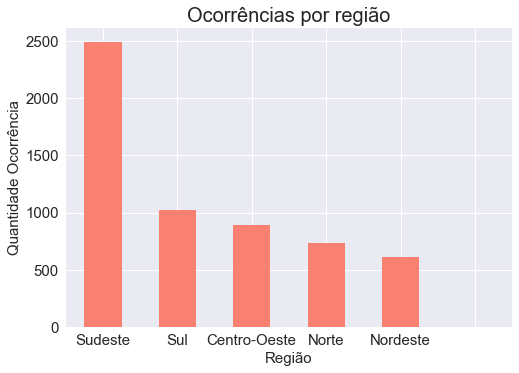

In [30]:
# Gráfico de barras
df['regiao'].value_counts().plot.bar(color='salmon', fontsize=15)
plt.title('Ocorrências por região',fontsize=20)
plt.xlabel('Região', fontsize=15)
plt.xticks(rotation='horizontal')
plt.ylabel('Quantidade Ocorrência', fontsize=15);

A região sudeste foi a que apresentou um maior número de ocorrências, no período de 2010 a 2020. Analisando especificamente essa região podemos encontrar quais foram os tipos de ocorrências que mais aconteceram na região sudeste.

In [31]:
# Ocorrências somente da região sudeste
df_sudeste['ocorrencia_classificacao'].value_counts()

INCIDENTE          1609
ACIDENTE            615
INCIDENTE GRAVE     269
Name: ocorrencia_classificacao, dtype: int64

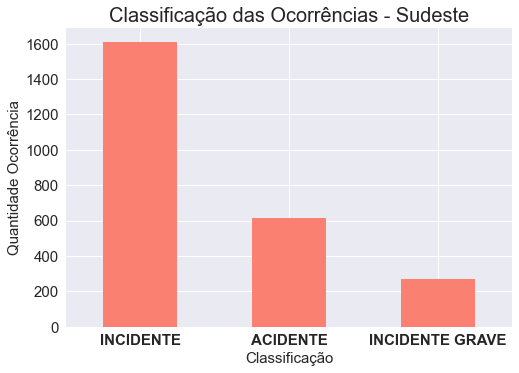

In [32]:
# Gráfico com a distribuição das classificações de ocorrências na região sudeste
df_sudeste['ocorrencia_classificacao'].value_counts().plot.bar(color='salmon', fontsize=15)
plt.title('Classificação das Ocorrências - Sudeste',fontsize=20)
plt.xlabel('Classificação', fontsize=15)
plt.xticks(rotation='horizontal', fontweight='bold')
plt.ylabel('Quantidade Ocorrência', fontsize=15);

Maior quantidade de ocorrências classifiadas como INCIDENTE

Vamos agora criar o mesmo gráfco a cima só que para as outras regiões do Brasil
 * Nordeste
 * Sul
 * Norte
 * Centro-Oeste

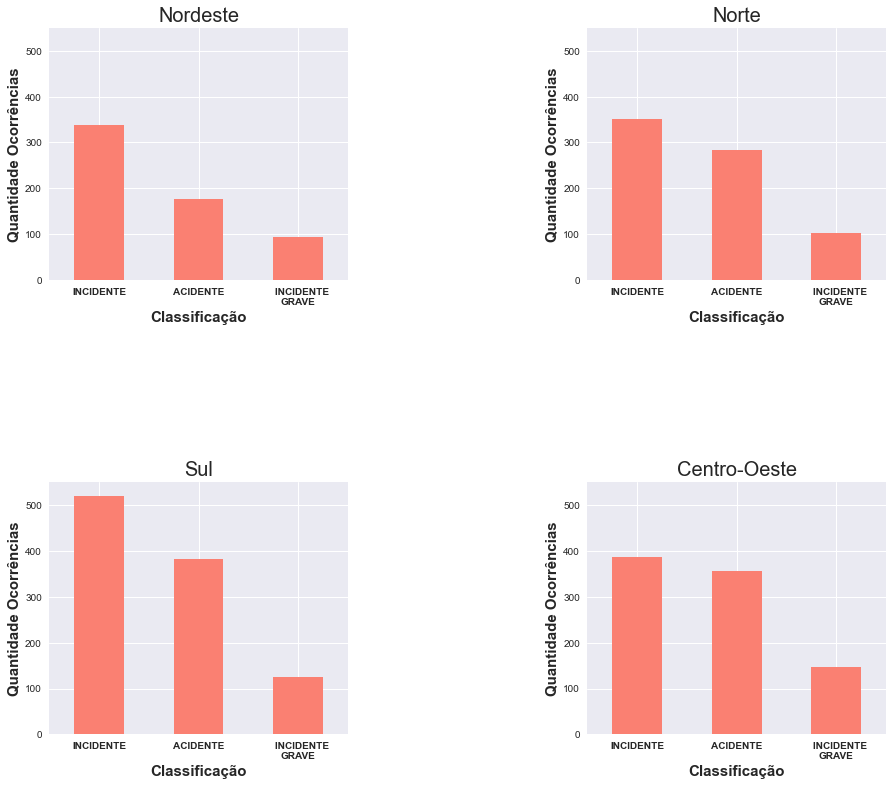

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,13))
fig.subplots_adjust(hspace=0.8, wspace=0.8)
legendas = ['INCIDENTE', 'ACIDENTE', '    INCIDENTE \nGRAVE']

#Gráfico 1 - Nordeste
df_nordeste.groupby('ocorrencia_classificacao')['ocorrencia_uf'].count().sort_values(ascending=False).plot.bar(ax=axes[0][0], color='salmon')
axes[0][0].set_title('Nordeste', fontsize=20)
axes[0][0].set_xlabel('Classificação', fontsize=15, fontweight='bold')
axes[0][0].set_xticklabels(legendas, rotation='horizontal', fontweight='bold', fontsize=10)
axes[0][0].set_ylabel('Quantidade Ocorrências', fontsize=15, fontweight='bold')
axes[0][0].set_ylim(0, 550)

#Gráfico 2 - Sul
df_sul.groupby('ocorrencia_classificacao')['ocorrencia_uf'].count().sort_values(ascending=False).plot.bar(ax=axes[1][0], color='salmon')
axes[1][0].set_title('Sul', fontsize=20)
axes[1][0].set_xlabel('Classificação', fontsize=15, fontweight='bold')
axes[1][0].set_xticklabels(legendas, rotation='horizontal', fontweight='bold', fontsize=10)
axes[1][0].set_ylabel('Quantidade Ocorrências', fontsize=15, fontweight='bold')
axes[1][0].set_ylim(0, 550)

#Gráfico 3 - Norte
df_norte.groupby('ocorrencia_classificacao')['ocorrencia_uf'].count().sort_values(ascending=False).plot.bar(ax=axes[0][1], color='salmon')
axes[0][1].set_title('Norte', fontsize=20)
axes[0][1].set_xlabel('Classificação', fontsize=15, fontweight='bold')
axes[0][1].set_xticklabels(legendas, rotation='horizontal', fontweight='bold', fontsize=10)
axes[0][1].set_ylabel('Quantidade Ocorrências', fontsize=15, fontweight='bold')
axes[0][1].set_ylim(0, 550)


#Gráfico 4 - Centro-Oeste
df_centro_oeste.groupby('ocorrencia_classificacao')['ocorrencia_uf'].count().sort_values(ascending=False).plot.bar(ax=axes[1][1], color='salmon')
axes[1][1].set_title('Centro-Oeste', fontsize=20)
axes[1][1].set_xlabel('Classificação', fontsize=15, fontweight='bold')
axes[1][1].set_xticklabels(legendas, rotation='horizontal', fontweight='bold', fontsize=10)
axes[1][1].set_ylabel('Quantidade Ocorrências', fontsize=15, fontweight='bold')
axes[1][1].set_ylim(0, 550);



### Região Sudeste

Sabemos que nesse conjunto de dados a região sudeste foi a que teve um maior número de ocorrências gerais e também o maior numero de ocorências em todas as classificações consideradas individualmente.

Vamos agora analisar com um pouco mais de detalhe a região sudeste.

In [34]:
#lembrando que foi criado um dataframe somente com os dados da região sudeste (df_sudeste). Vamos utilizá-lo
df_sudeste.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2493 entries, 0 to 5751
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   codigo_ocorrencia         2493 non-null   int64         
 1   codigo_ocorrencia2        2493 non-null   int64         
 2   ocorrencia_classificacao  2493 non-null   object        
 3   ocorrencia_cidade         2493 non-null   object        
 4   ocorrencia_uf             2493 non-null   object        
 5   ocorrencia_aerodromo      1585 non-null   object        
 6   ocorrencia_dia            2493 non-null   datetime64[ns]
 7   ocorrencia_hora           2493 non-null   object        
 8   total_recomendacoes       2493 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 194.8+ KB


* O conjunto de dados do sudeste tem 2493 linhas

In [35]:
# Quantidades de ocorrências em cada estado da região sudeste
df_sudeste['ocorrencia_uf'].value_counts()

SP    1373
MG     529
RJ     516
ES      75
Name: ocorrencia_uf, dtype: int64

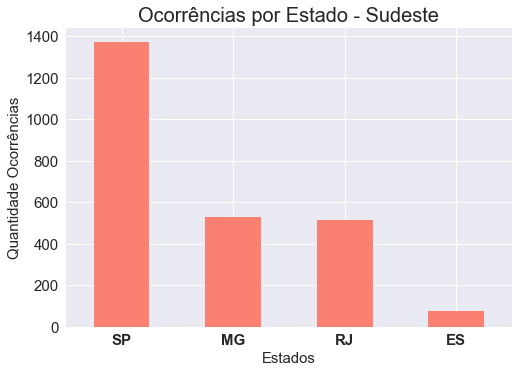

In [36]:
# Gráfico de barras da quantidade de ocorrências por estados da região sudeste
df_sudeste['ocorrencia_uf'].value_counts().plot.bar(color='salmon', fontsize=15);
plt.title('Ocorrências por Estado - Sudeste',fontsize=20)
plt.xlabel('Estados', fontsize=15)
plt.xticks(rotation='horizontal', fontweight='bold')
plt.ylabel('Quantidade Ocorrências', fontsize=15);

A maior parte das ocorrências da região sudeste são do estado de São Paulo!

Podemos ver esses mesmos dados em forma de porentagem

In [37]:
#primeiro vamos guardar o total de valores em uma variável - total
total = df_sudeste['ocorrencia_uf'].count()
total

2493

In [38]:
# Agora vamos separar em um dicionário os valores de ocorrências individuais de cada estado 
estados = dict(df_sudeste['ocorrencia_uf'].value_counts())
estados

{'SP': 1373, 'MG': 529, 'RJ': 516, 'ES': 75}

In [39]:
#valores
estados.values()

dict_values([1373, 529, 516, 75])

In [40]:
# chaves - os estados
estados.keys()

dict_keys(['SP', 'MG', 'RJ', 'ES'])

In [41]:
# Para cada valor de estado no dicionário estados, está sendo calculada a porcentagem que esse valor representa no total
porcentagens = []
for values in estados:
    percen = (estados[values]/ total) * 100
    porcentagens.append(percen.round(2))
    print(percen.round(2))

55.07
21.22
20.7
3.01


In [42]:
# as porcentagens foram armazenadas em uma lista de nome, porcentagens
porcentagens

[55.07, 21.22, 20.7, 3.01]

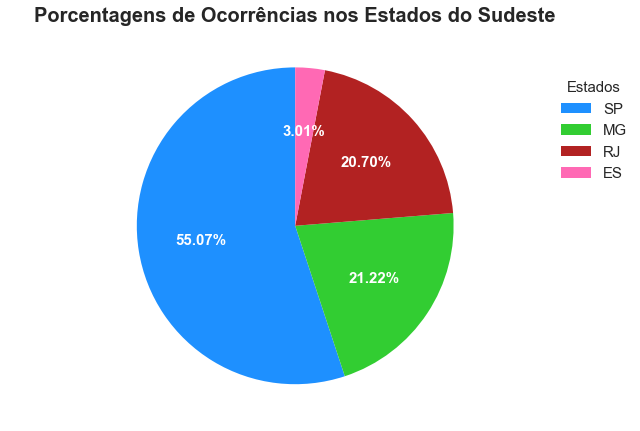

In [43]:
# Gráfico de pizza
uf = list(estados.keys())
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
cores = ['dodgerblue', 'limegreen', 'firebrick', 'hotpink']
ax.pie(porcentagens, labels = uf, autopct='%1.2f%%', startangle=90, colors=cores, labeldistance=None,
       textprops=dict(color="w", fontweight='bold', fontsize=15))
      
plt.title('Porcentagens de Ocorrências nos Estados do Sudeste', fontsize=20,  fontweight='bold', loc='center')
plt.legend(title='Estados',title_fontsize=15, fontsize=15, bbox_to_anchor=(1.1, 0.9), loc='best')

plt.show()

**São Paulo foi o estado da região sudeste que mais teve ocorrências.**

In [44]:
# Criando uma nova coluna chamada Ano
df_sudeste['Ano'] = df.ocorrencia_dia.dt.year

<ipython-input-44-7b5037289413>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sudeste['Ano'] = df.ocorrencia_dia.dt.year


In [45]:
df_sudeste.head()

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes,Ano
0,40211,40211,INCIDENTE,RIO DE JANEIRO,RJ,<NA>,2010-01-03,12:00:00,0,2010
2,40351,40351,INCIDENTE,RIO DE JANEIRO,RJ,SBRJ,2010-01-03,03:00:00,0,2010
9,39711,39711,INCIDENTE GRAVE,PARÁ DE MINAS,MG,<NA>,2010-01-10,20:00:00,0,2010
11,40069,40069,ACIDENTE,SÃO PAULO,SP,SBMT,2010-01-10,14:50:00,8,2010
16,39809,39809,INCIDENTE,SÃO PAULO,SP,<NA>,2010-01-15,15:00:00,0,2010


Com a coluna Ano criada agora podemos fazer uma análise da progressão da quantidade de ocorrências ao longo do tempo.

In [46]:
df_sudeste['Ano'].value_counts().sort_values(ascending=False)

2012    304
2013    304
2011    262
2014    234
2010    228
2020    223
2015    207
2019    205
2018    195
2017    172
2016    159
Name: Ano, dtype: int64

In [47]:
valores = df_sudeste['Ano'].value_counts()

In [48]:
anos=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

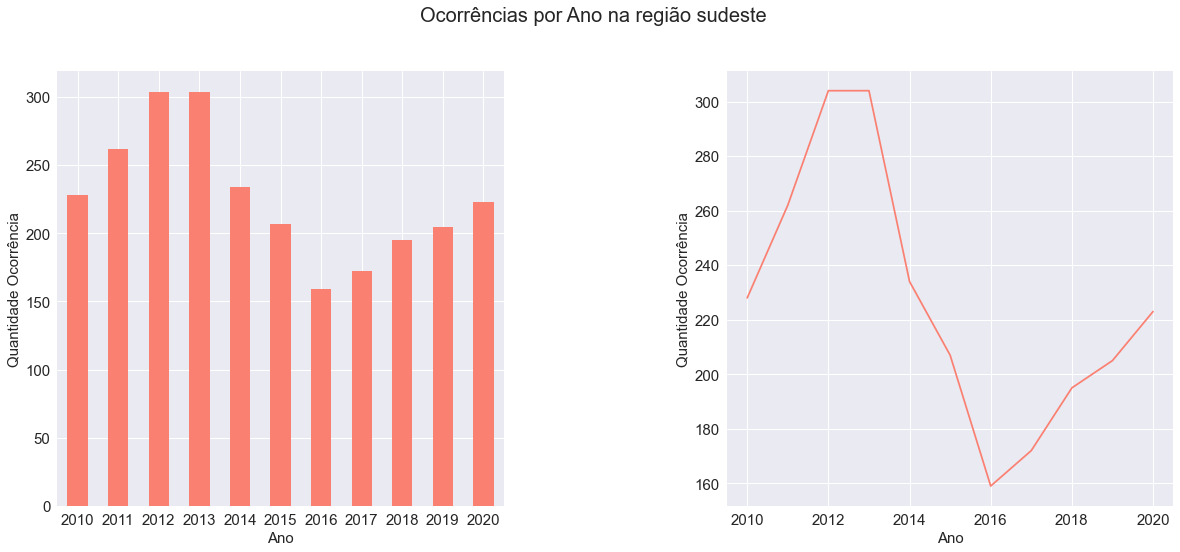

In [49]:
# ocorrencias na região sudeste ao longo dos anos

fig, axes = plt.subplots(nrows=1, ncols=2, squeeze = False, figsize=(20,8))
fig.subplots_adjust(hspace=0.8, wspace=0.5)

#Gráfico 1 - Barras
valores.loc[anos].plot.bar(ax=axes[0][0], color='salmon', fontsize=15)
axes[0][0].set_title('Ocorrências por Ano na região sudeste',fontsize=20, position=(1.2, 1.1))
axes[0][0].set_xlabel('Ano', fontsize=15)
axes[0][0].set_xticklabels(labels= anos, rotation='horizontal')
axes[0][0].set_ylabel('Quantidade Ocorrência', fontsize=15)

#Gráfico 2 - Linha
labelx=[2010, 2012, 2014, 2016, 2018, 2020]
valores.loc[anos].plot(ax=axes[0][1],color='salmon', fontsize=15)
axes[0][1].set_xlabel('Ano', fontsize=15)
axes[0][1].set_ylabel('Quantidade Ocorrência', fontsize=15);



**Podemos observar com esse dois tipos de gráficos que os anos de 2012 e 2013, foram os que tiveram o maior número de ocorrências na região Sudeste.**

### Região Nordeste

In [50]:
df_nordeste.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608 entries, 5 to 5738
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   codigo_ocorrencia         608 non-null    int64         
 1   codigo_ocorrencia2        608 non-null    int64         
 2   ocorrencia_classificacao  608 non-null    object        
 3   ocorrencia_cidade         608 non-null    object        
 4   ocorrencia_uf             608 non-null    object        
 5   ocorrencia_aerodromo      370 non-null    object        
 6   ocorrencia_dia            608 non-null    datetime64[ns]
 7   ocorrencia_hora           608 non-null    object        
 8   total_recomendacoes       608 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 47.5+ KB


In [51]:
df_nordeste.head()

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes
5,39807,39807,INCIDENTE,SALVADOR,BA,<NA>,2010-01-06,17:53:00,0
17,39810,39810,INCIDENTE,SALVADOR,BA,<NA>,2010-01-15,18:23:00,0
42,39747,39747,INCIDENTE,CAIRU,BA,SNCL,2010-01-31,19:47:00,4
47,39176,39176,INCIDENTE,SÃO LUÍS,MA,<NA>,2010-02-05,09:30:00,0
51,39115,39115,ACIDENTE,CORRENTINA,BA,SNTY,2010-02-07,17:40:00,2


In [52]:
#quantidade de ocorrências por estados da região nordeste
df_nordeste['ocorrencia_uf'].value_counts()

BA    213
PE     98
CE     88
MA     75
PI     40
AL     33
PB     24
SE     21
RN     16
Name: ocorrencia_uf, dtype: int64

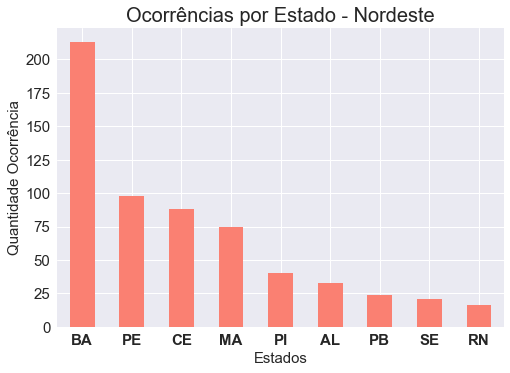

In [53]:
# Gráfico de barras da quantidade de ocorrências por estados da região nordeste
df_nordeste['ocorrencia_uf'].value_counts().plot.bar(color='salmon', fontsize=15);
plt.title('Ocorrências por Estado - Nordeste',fontsize=20)
plt.xlabel('Estados', fontsize=15)
plt.xticks(rotation='horizontal', fontweight='bold')
plt.ylabel('Quantidade Ocorrência', fontsize=15);

**O estado com maior número de ocorrências da região nordeste foi a Bahia.**

In [54]:
# Visualização dos resultados em porentagem

#primeiro vamos guardar o total de valores em uma variável - total
total = df_nordeste['ocorrencia_uf'].count()

# Agora vamos separar em um dicionário os valores de ocorrências individuais de cada estado 
estados = dict(df_nordeste['ocorrencia_uf'].value_counts())

print(total)
print(estados)

608
{'BA': 213, 'PE': 98, 'CE': 88, 'MA': 75, 'PI': 40, 'AL': 33, 'PB': 24, 'SE': 21, 'RN': 16}


In [55]:
# Para cada valor de estado no dicionário estados, está sendo calculada a porcentagem que esse valor representa no total
porcentagens = []
for values in estados:
    percen = (estados[values]/ total) * 100
    porcentagens.append(percen.round(2))
    print(percen.round(2))
# as porcentagens foram armazenadas em uma lista de nome, porcentagens
print('Porcentagens:',porcentagens)

35.03
16.12
14.47
12.34
6.58
5.43
3.95
3.45
2.63
Porcentagens: [35.03, 16.12, 14.47, 12.34, 6.58, 5.43, 3.95, 3.45, 2.63]


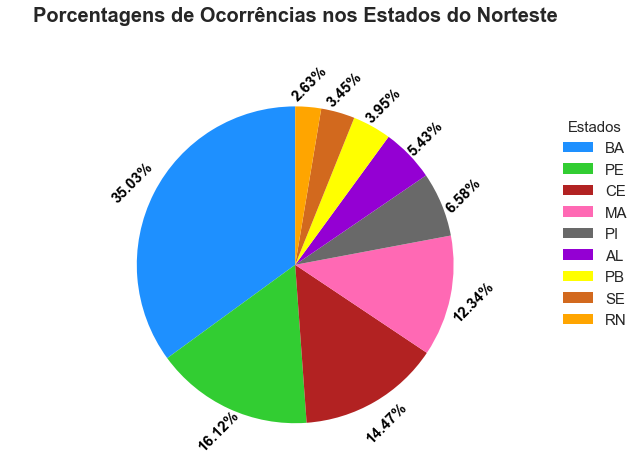

In [56]:
# Gráfico de pizza
uf = list(estados.keys())
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
cores = ['dodgerblue', 'limegreen', 'firebrick', 'hotpink', 'dimgrey', 'darkviolet', 'yellow', 'chocolate', 'orange']
ax.pie(porcentagens, labels = uf, autopct='%1.2f%%', pctdistance=1.15, startangle=90, colors=cores, labeldistance=None,
       textprops=dict(color="black", fontweight='bold', fontsize=15, horizontalalignment="center", rotation=45))
      
plt.title('Porcentagens de Ocorrências nos Estados do Norteste', fontsize=20,  fontweight='bold', loc='center',position=(0.5, 1.1))
plt.legend(title='Estados',title_fontsize=15, fontsize=15, bbox_to_anchor=(1.1, 0.9), loc='best')

plt.show()

**Os Estados como maior número de ocorrências:**
* Bahia
* Pernambuco
* Ceará


In [57]:
# Vamos fazer a análise das ocorrências ao longo dos anos.
# Criando a coluna Ano para o df_nordeste
df_nordeste['Ano'] = df.ocorrencia_dia.dt.year

<ipython-input-57-023acdc49afb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nordeste['Ano'] = df.ocorrencia_dia.dt.year


In [58]:
df_nordeste.head()

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes,Ano
5,39807,39807,INCIDENTE,SALVADOR,BA,<NA>,2010-01-06,17:53:00,0,2010
17,39810,39810,INCIDENTE,SALVADOR,BA,<NA>,2010-01-15,18:23:00,0,2010
42,39747,39747,INCIDENTE,CAIRU,BA,SNCL,2010-01-31,19:47:00,4,2010
47,39176,39176,INCIDENTE,SÃO LUÍS,MA,<NA>,2010-02-05,09:30:00,0,2010
51,39115,39115,ACIDENTE,CORRENTINA,BA,SNTY,2010-02-07,17:40:00,2,2010


In [59]:
# Números de ocorrências no nordeste por ano
df_nordeste['Ano'].value_counts().sort_values(ascending=False)

2010    76
2012    67
2014    67
2018    60
2013    57
2011    55
2015    52
2019    50
2020    48
2016    42
2017    34
Name: Ano, dtype: int64

In [60]:
valores = df_nordeste['Ano'].value_counts()
anos=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

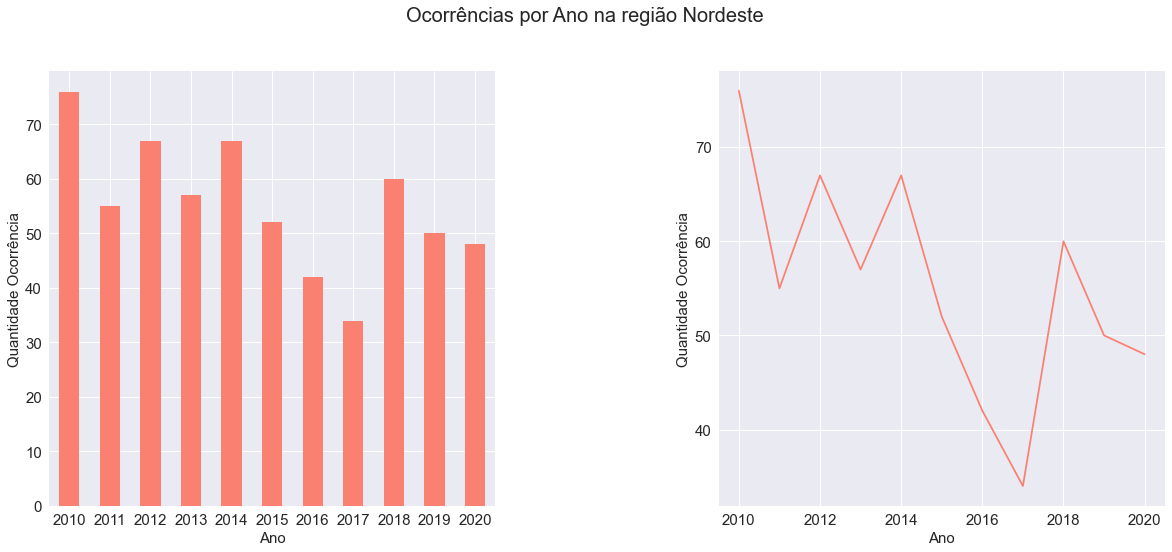

In [61]:
# ocorrencias na região nordeste ao longo dos anos
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze = False, figsize=(20,8))
fig.subplots_adjust(hspace=0.8, wspace=0.5)


#Gráfico 1 - Barras
valores.loc[anos].plot.bar(ax=axes[0][0], color='salmon', fontsize=15)
axes[0][0].set_title('Ocorrências por Ano na região Nordeste',fontsize=20, position=(1.2, 1.1))
axes[0][0].set_xlabel('Ano', fontsize=15)
axes[0][0].set_xticklabels(labels= anos, rotation='horizontal')
axes[0][0].set_ylabel('Quantidade Ocorrência', fontsize=15)

#Gráfico 2 - Linha
labelx=[2010, 2012, 2014, 2016, 2018, 2020]
valores.loc[anos].plot(ax=axes[0][1],color='salmon', fontsize=15)
axes[0][1].set_xlabel('Ano', fontsize=15)
axes[0][1].set_ylabel('Quantidade Ocorrência', fontsize=15);



**Podemos observar com esse dois tipos de gráficos que os anos de 2010, 2012 e 2014, foram os que tiveram o maior número de ocorrências na região Nordeste.**

### Região Centro-Oeste

In [62]:
df_centro_oeste.head()

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes
3,39527,39527,ACIDENTE,LUCAS DO RIO VERDE,MT,<NA>,2010-01-04,17:30:00,0
12,40414,40414,INCIDENTE,BRASÍLIA,DF,SBBR,2010-01-10,03:00:00,0
13,39507,39507,ACIDENTE,PRIMAVERA DO LESTE,MT,<NA>,2010-01-11,17:00:00,2
28,39321,39321,ACIDENTE,PONTES E LACERDA,MT,<NA>,2010-01-23,13:00:00,2
43,39787,39787,INCIDENTE,GOIÂNIA,GO,SBGO,2010-01-31,21:00:00,0


In [63]:
df_centro_oeste.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 3 to 5750
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   codigo_ocorrencia         887 non-null    int64         
 1   codigo_ocorrencia2        887 non-null    int64         
 2   ocorrencia_classificacao  887 non-null    object        
 3   ocorrencia_cidade         887 non-null    object        
 4   ocorrencia_uf             887 non-null    object        
 5   ocorrencia_aerodromo      429 non-null    object        
 6   ocorrencia_dia            887 non-null    datetime64[ns]
 7   ocorrencia_hora           886 non-null    object        
 8   total_recomendacoes       887 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 69.3+ KB


In [64]:
# quantidade de ocorrências por estado da região centro-oeste.
df_centro_oeste['ocorrencia_uf'].value_counts()

GO    309
MT    292
MS    151
DF    135
Name: ocorrencia_uf, dtype: int64

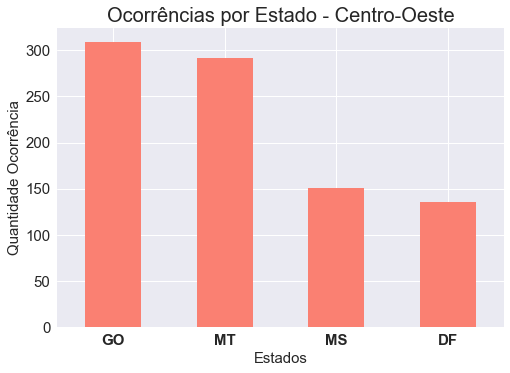

In [65]:
# Gráfico de barras da quantidade de ocorrências por estados da região centro-oeste
df_centro_oeste['ocorrencia_uf'].value_counts().plot.bar(color='salmon', fontsize=15);
plt.title('Ocorrências por Estado - Centro-Oeste',fontsize=20)
plt.xlabel('Estados', fontsize=15)
plt.xticks(rotation='horizontal', fontweight='bold')
plt.ylabel('Quantidade Ocorrência', fontsize=15);

**Goáis e Mato Grosso são os estados da região centro-oeste com maios incidentes.**

In [66]:
# Visualização dos dados em porcentagem

#primeiro vamos guardar o total de valores em uma variável - total
total = df_centro_oeste['ocorrencia_uf'].count()

# Agora vamos separar em um dicionário os valores de ocorrências individuais de cada estado 
estados = dict(df_centro_oeste['ocorrencia_uf'].value_counts())

print(total)
print(estados)

887
{'GO': 309, 'MT': 292, 'MS': 151, 'DF': 135}


In [67]:
# Para cada valor de estado no dicionário estados, está sendo calculada a porcentagem que esse valor representa no total
porcentagens = []
for values in estados:
    percen = (estados[values]/ total) * 100
    porcentagens.append(percen.round(2))
    print(percen.round(2))
# as porcentagens foram armazenadas em uma lista de nome, porcentagens
print('Porcentagens:',porcentagens)

34.84
32.92
17.02
15.22
Porcentagens: [34.84, 32.92, 17.02, 15.22]


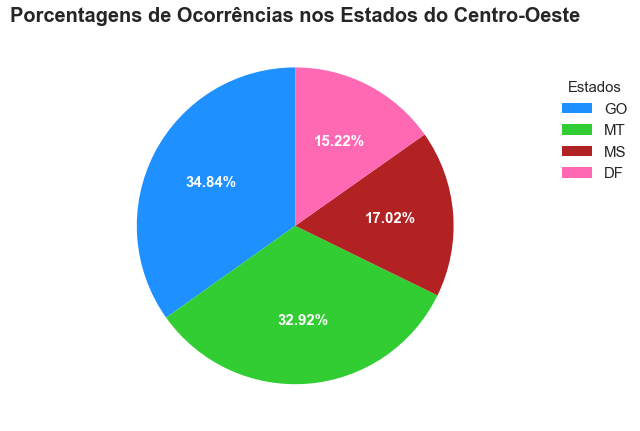

In [68]:
# Gráfico de pizza
uf = list(estados.keys())
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
cores = ['dodgerblue', 'limegreen', 'firebrick', 'hotpink']
ax.pie(porcentagens, labels = uf, autopct='%1.2f%%', startangle=90, colors=cores, labeldistance=None,
       textprops=dict(color="w", fontweight='bold', fontsize=15))
      
plt.title('Porcentagens de Ocorrências nos Estados do Centro-Oeste', fontsize=20,  fontweight='bold', loc='center')
plt.legend(title='Estados',title_fontsize=15, fontsize=15, bbox_to_anchor=(1.1, 0.9), loc='best')

plt.show()

In [69]:
# Análise das ocorrências ao longo dos anos na região centro-oeste
# Criando a coluna Ano para o df_centro_oeste
df_centro_oeste['Ano'] = df.ocorrencia_dia.dt.year

<ipython-input-69-8652c8d03da4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_centro_oeste['Ano'] = df.ocorrencia_dia.dt.year


In [70]:
df_centro_oeste.head()

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes,Ano
3,39527,39527,ACIDENTE,LUCAS DO RIO VERDE,MT,<NA>,2010-01-04,17:30:00,0,2010
12,40414,40414,INCIDENTE,BRASÍLIA,DF,SBBR,2010-01-10,03:00:00,0,2010
13,39507,39507,ACIDENTE,PRIMAVERA DO LESTE,MT,<NA>,2010-01-11,17:00:00,2,2010
28,39321,39321,ACIDENTE,PONTES E LACERDA,MT,<NA>,2010-01-23,13:00:00,2,2010
43,39787,39787,INCIDENTE,GOIÂNIA,GO,SBGO,2010-01-31,21:00:00,0,2010


In [71]:
# Número de ocorrência na região centro-oeste ao longo dos anos.
df_centro_oeste['Ano'].value_counts().sort_values(ascending=False)

2013    103
2011    101
2012     98
2019     86
2010     84
2020     83
2014     76
2015     65
2018     65
2016     63
2017     63
Name: Ano, dtype: int64

In [72]:
valores = df_centro_oeste['Ano'].value_counts()
anos=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

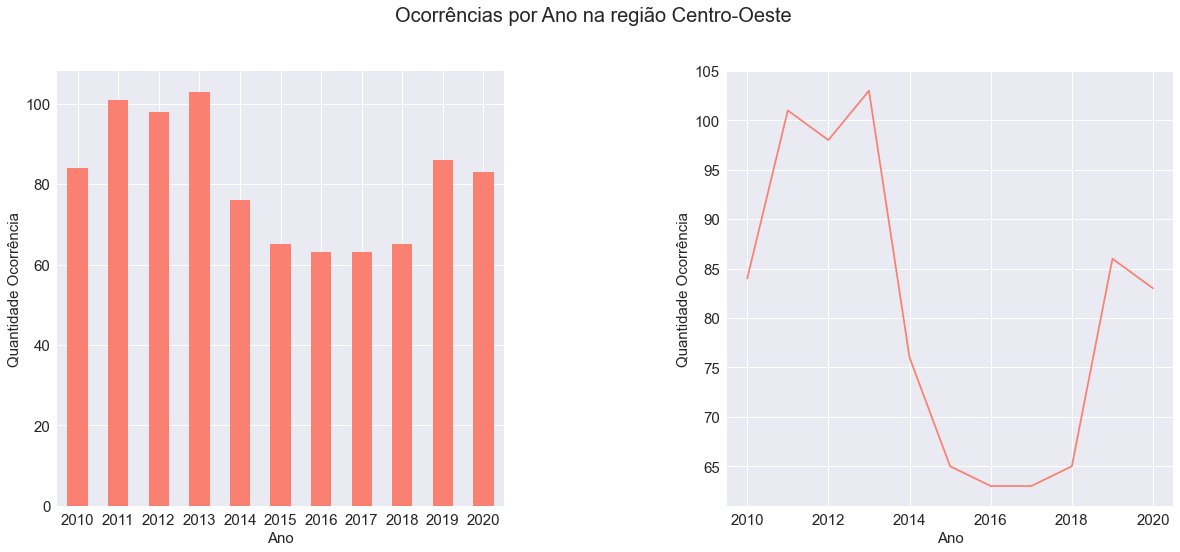

In [73]:
# ocorrencias na região centro-oeste ao longo dos anos
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze = False, figsize=(20,8))
fig.subplots_adjust(hspace=0.8, wspace=0.5)

#Gráfico 1 - Barras
valores.loc[anos].plot.bar(ax=axes[0][0], color='salmon', fontsize=15)
axes[0][0].set_title('Ocorrências por Ano na região Centro-Oeste',fontsize=20, position=(1.2, 1.1))
axes[0][0].set_xlabel('Ano', fontsize=15)
axes[0][0].set_xticklabels(labels= anos, rotation='horizontal')
axes[0][0].set_ylabel('Quantidade Ocorrência', fontsize=15)

#Gráfico 2 - Linha
labelx=[2010, 2012, 2014, 2016, 2018, 2020]
valores.loc[anos].plot(ax=axes[0][1],color='salmon', fontsize=15)
axes[0][1].set_xlabel('Ano', fontsize=15)
axes[0][1].set_ylabel('Quantidade Ocorrência', fontsize=15);



**Podemos observar com esse dois tipos de gráficos que os anos de 2011 e 2013 foram os que tiveram o maior número de ocorrências na região Centro-Oeste.**

### Região Sul

In [74]:
df_sul.head()

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes
4,40324,40324,INCIDENTE,PELOTAS,RS,SBPK,2010-01-05,19:25:00,0
8,39156,39156,INCIDENTE GRAVE,CASCAVEL,PR,SBCA,2010-01-10,23:15:00,2
10,39789,39789,INCIDENTE,SÃO PEDRO DO SUL,RS,<NA>,2010-01-10,21:30:00,0
21,39320,39320,ACIDENTE,FAROL,PR,<NA>,2010-01-19,18:30:00,4
22,39851,39851,INCIDENTE,PASSO FUNDO,RS,SBPF,2010-01-19,03:00:00,0


In [75]:
df_sul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1026 entries, 4 to 5745
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   codigo_ocorrencia         1026 non-null   int64         
 1   codigo_ocorrencia2        1026 non-null   int64         
 2   ocorrencia_classificacao  1026 non-null   object        
 3   ocorrencia_cidade         1026 non-null   object        
 4   ocorrencia_uf             1026 non-null   object        
 5   ocorrencia_aerodromo      615 non-null    object        
 6   ocorrencia_dia            1026 non-null   datetime64[ns]
 7   ocorrencia_hora           1026 non-null   object        
 8   total_recomendacoes       1026 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 80.2+ KB


In [76]:
# número de ocorrências em cada estado do Sul
df_sul['ocorrencia_uf'].value_counts()

PR    485
RS    352
SC    189
Name: ocorrencia_uf, dtype: int64

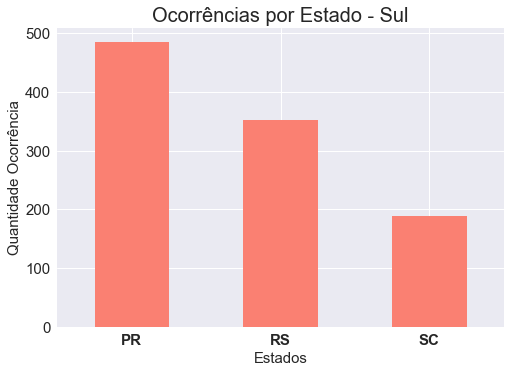

In [77]:
# Gráfico de barras da quantidade de ocorrências por estados da região sul
df_sul['ocorrencia_uf'].value_counts().plot.bar(color='salmon', fontsize=15);
plt.title('Ocorrências por Estado - Sul',fontsize=20)
plt.xlabel('Estados', fontsize=15)
plt.xticks(rotation='horizontal', fontweight='bold')
plt.ylabel('Quantidade Ocorrência', fontsize=15);

**Paraná é o estados da região sul com maios incidentes.**

In [78]:
# Visualização dos dados em forma de porcentagem

#primeiro vamos guardar o total de valores em uma variável - total
total = df_sul['ocorrencia_uf'].count()

# Agora vamos separar em um dicionário os valores de ocorrências individuais de cada estado 
estados = dict(df_sul['ocorrencia_uf'].value_counts())

print(total)
print(estados)

1026
{'PR': 485, 'RS': 352, 'SC': 189}


In [79]:
# Para cada valor de estado no dicionário estados, está sendo calculada a porcentagem que esse valor representa no total
porcentagens = []
for values in estados:
    percen = (estados[values]/ total) * 100
    porcentagens.append(percen.round(2))
    print(percen.round(2))
# as porcentagens foram armazenadas em uma lista de nome, porcentagens
print('Porcentagens:',porcentagens)

47.27
34.31
18.42
Porcentagens: [47.27, 34.31, 18.42]


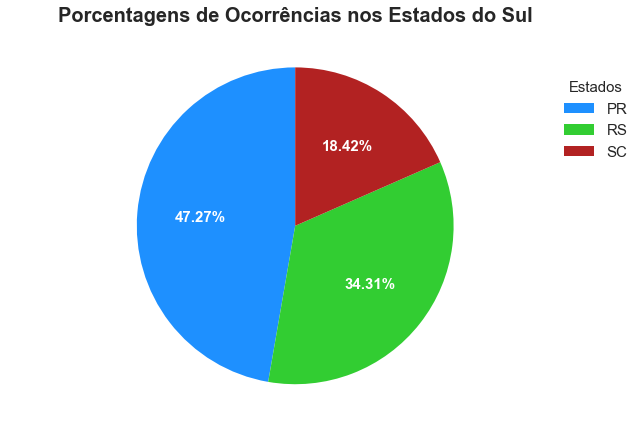

In [80]:
# Gráfico de pizza
uf = list(estados.keys())
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
cores = ['dodgerblue', 'limegreen', 'firebrick']
ax.pie(porcentagens, labels = uf, autopct='%1.2f%%', startangle=90, colors=cores, labeldistance=None,
       textprops=dict(color="w", fontweight='bold', fontsize=15))
      
plt.title('Porcentagens de Ocorrências nos Estados do Sul', fontsize=20,  fontweight='bold', loc='center')
plt.legend(title='Estados',title_fontsize=15, fontsize=15, bbox_to_anchor=(1.1, 0.9), loc='best')

plt.show()

In [81]:
# Análise das ocorrências na região sul ao longo dos anos.
# Criando coluna Ano para o df_sul
df_sul['Ano'] = df.ocorrencia_dia.dt.year

<ipython-input-81-9449068b5777>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sul['Ano'] = df.ocorrencia_dia.dt.year


In [82]:
df_sul.head()

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes,Ano
4,40324,40324,INCIDENTE,PELOTAS,RS,SBPK,2010-01-05,19:25:00,0,2010
8,39156,39156,INCIDENTE GRAVE,CASCAVEL,PR,SBCA,2010-01-10,23:15:00,2,2010
10,39789,39789,INCIDENTE,SÃO PEDRO DO SUL,RS,<NA>,2010-01-10,21:30:00,0,2010
21,39320,39320,ACIDENTE,FAROL,PR,<NA>,2010-01-19,18:30:00,4,2010
22,39851,39851,INCIDENTE,PASSO FUNDO,RS,SBPF,2010-01-19,03:00:00,0,2010


In [83]:
# Número de ocorrências da região sul em cada ano.
df_sul['Ano'].value_counts().sort_values(ascending=False)

2013    114
2017    105
2014     97
2016     97
2015     95
2012     93
2019     93
2010     89
2020     85
2011     84
2018     74
Name: Ano, dtype: int64

In [84]:
valores = df_sul['Ano'].value_counts()
anos=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

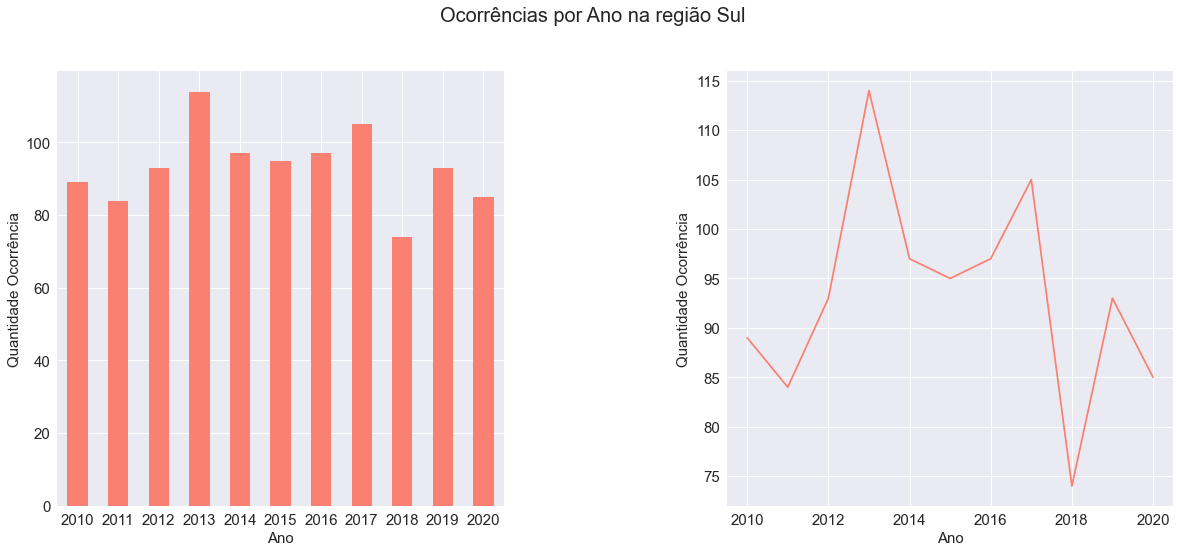

In [85]:
# ocorrencias na região sul ao longo dos anos
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze = False, figsize=(20,8))
fig.subplots_adjust(hspace=0.8, wspace=0.5)

#Gráfico 1 - Barra
valores.loc[anos].plot.bar(ax=axes[0][0], color='salmon', fontsize=15)
axes[0][0].set_title('Ocorrências por Ano na região Sul',fontsize=20, position=(1.2, 1.1))
axes[0][0].set_xlabel('Ano', fontsize=15)
axes[0][0].set_xticklabels(labels= anos, rotation='horizontal')
axes[0][0].set_ylabel('Quantidade Ocorrência', fontsize=15)

#Gráfico 2 - Linha
labelx=[2010, 2012, 2014, 2016, 2018, 2020]
valores.loc[anos].plot(ax=axes[0][1],color='salmon', fontsize=15)
axes[0][1].set_xlabel('Ano', fontsize=15)
axes[0][1].set_ylabel('Quantidade Ocorrência', fontsize=15);



**Podemos observar com esse dois tipos de gráficos que os anos de 2013 e 2017 foram os que tiveram o maior número de ocorrências na região Sul.**

### Região Norte

In [86]:
df_norte.head()

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes
1,40349,40349,INCIDENTE,BELÉM,PA,SBBE,2010-01-03,11:05:00,0
6,40215,40215,INCIDENTE,COARI,AM,SBUY,2010-01-07,18:40:00,0
7,39707,39707,INCIDENTE GRAVE,CANUTAMA,AM,<NA>,2010-01-09,12:30:00,3
14,40107,40107,ACIDENTE,GURUPÁ,PA,SNGU,2010-01-12,14:30:00,0
15,39315,39315,ACIDENTE,CANUTAMA,AM,<NA>,2010-01-15,21:22:00,0


In [87]:
df_norte.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737 entries, 1 to 5748
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   codigo_ocorrencia         737 non-null    int64         
 1   codigo_ocorrencia2        737 non-null    int64         
 2   ocorrencia_classificacao  737 non-null    object        
 3   ocorrencia_cidade         737 non-null    object        
 4   ocorrencia_uf             737 non-null    object        
 5   ocorrencia_aerodromo      404 non-null    object        
 6   ocorrencia_dia            737 non-null    datetime64[ns]
 7   ocorrencia_hora           737 non-null    object        
 8   total_recomendacoes       737 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 57.6+ KB


In [88]:
# Número de ocorrências em cada estado da região Norte
df_norte['ocorrencia_uf'].value_counts()

PA    287
AM    233
AC     58
RR     55
TO     54
RO     37
AP     13
Name: ocorrencia_uf, dtype: int64

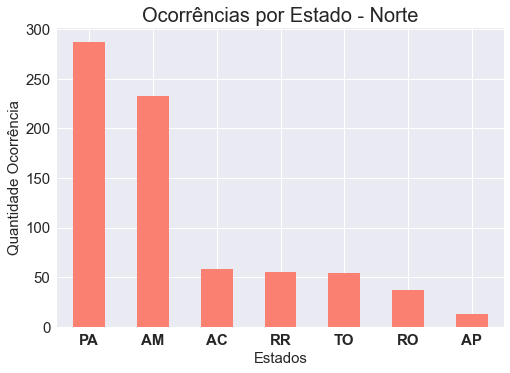

In [89]:
# Gráfico de barras da quantidade de ocorrências por estados da região norte
df_norte['ocorrencia_uf'].value_counts().plot.bar(color='salmon', fontsize=15);
plt.title('Ocorrências por Estado - Norte',fontsize=20)
plt.xlabel('Estados', fontsize=15)
plt.xticks(rotation='horizontal', fontweight='bold')
plt.ylabel('Quantidade Ocorrência', fontsize=15);

**Os estados do Pará e Amazonas foram os que tiveram o maior número de ocorrências na região Norte.**

In [90]:
# Visualização dos resultados em porcentagem

#primeiro vamos guardar o total de valores em uma variável - total
total = df_norte['ocorrencia_uf'].count()

# Agora vamos separar em um dicionário os valores de ocorrências individuais de cada estado 
estados = dict(df_norte['ocorrencia_uf'].value_counts())

print(total)
print(estados)

737
{'PA': 287, 'AM': 233, 'AC': 58, 'RR': 55, 'TO': 54, 'RO': 37, 'AP': 13}


In [91]:
# Para cada valor de estado no dicionário estados, está sendo calculada a porcentagem que esse valor representa no total
porcentagens = []
for values in estados:
    percen = (estados[values]/ total) * 100
    porcentagens.append(percen.round(2))
    print(percen.round(2))
# as porcentagens foram armazenadas em uma lista de nome, porcentagens
print('Porcentagens:',porcentagens)

38.94
31.61
7.87
7.46
7.33
5.02
1.76
Porcentagens: [38.94, 31.61, 7.87, 7.46, 7.33, 5.02, 1.76]


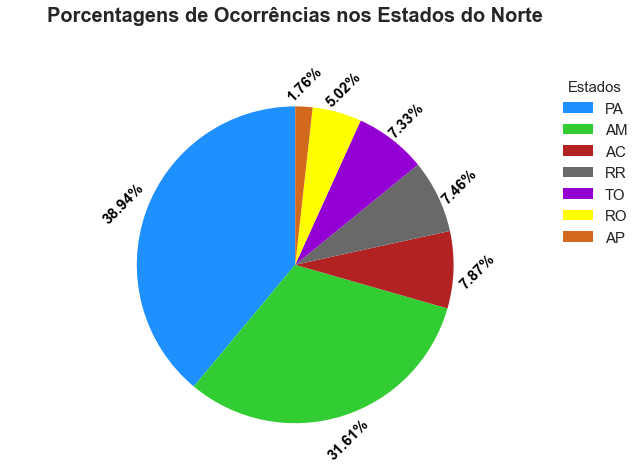

In [92]:
# Gráfico de pizza
uf = list(estados.keys())
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
cores = ['dodgerblue', 'limegreen', 'firebrick', 'dimgrey', 'darkviolet', 'yellow','chocolate']
ax.pie(porcentagens, labels = uf, autopct='%1.2f%%', pctdistance=1.15, startangle=90, colors=cores, labeldistance=None,
       textprops=dict(color="black", fontweight='bold', fontsize=15, horizontalalignment="center", rotation=45))
      
plt.title('Porcentagens de Ocorrências nos Estados do Norte', fontsize=20,  fontweight='bold', loc='center', position=(0.5, 1.1))
plt.legend(title='Estados',title_fontsize=15, fontsize=15, bbox_to_anchor=(1.1, 1.0), loc='upper right')

plt.show()

In [93]:
#Análise do número de ocorrências na região Norte ao longo dos anos.
# Criando a coluna Ano para o df_norte
df_norte['Ano'] = df.ocorrencia_dia.dt.year

<ipython-input-93-6a67ad360ec3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norte['Ano'] = df.ocorrencia_dia.dt.year


In [94]:
df_norte.head()

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes,Ano
1,40349,40349,INCIDENTE,BELÉM,PA,SBBE,2010-01-03,11:05:00,0,2010
6,40215,40215,INCIDENTE,COARI,AM,SBUY,2010-01-07,18:40:00,0,2010
7,39707,39707,INCIDENTE GRAVE,CANUTAMA,AM,<NA>,2010-01-09,12:30:00,3,2010
14,40107,40107,ACIDENTE,GURUPÁ,PA,SNGU,2010-01-12,14:30:00,0,2010
15,39315,39315,ACIDENTE,CANUTAMA,AM,<NA>,2010-01-15,21:22:00,0,2010


In [95]:
# Ocorrências em cada ano
df_norte['Ano'].value_counts().sort_values(ascending=False)

2014    93
2012    85
2010    75
2013    75
2011    74
2020    71
2019    62
2017    58
2015    52
2018    50
2016    42
Name: Ano, dtype: int64

In [96]:
valores = df_norte['Ano'].value_counts()
anos=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

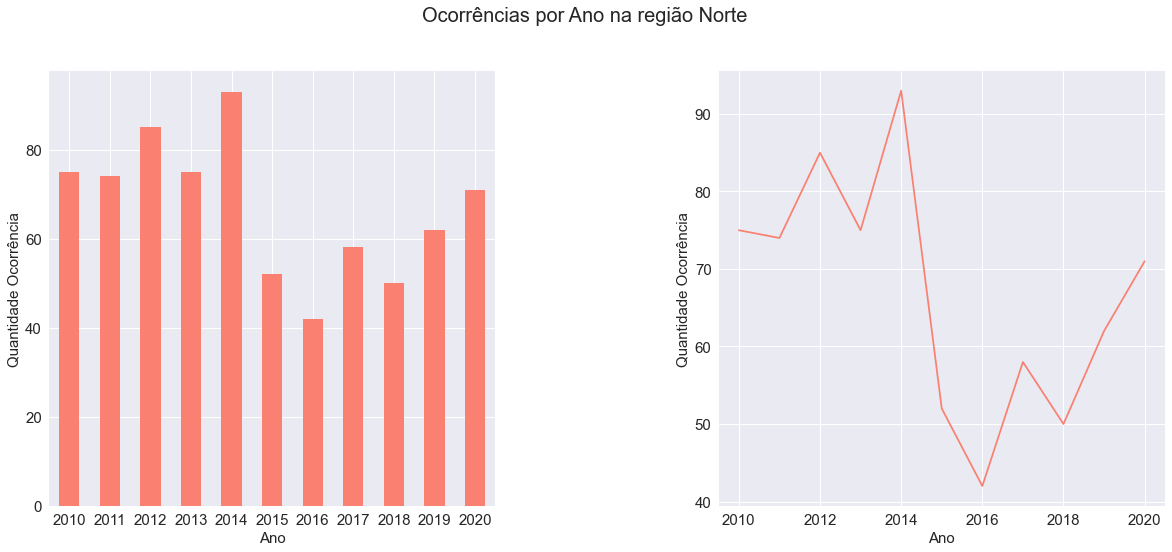

In [97]:
# ocorrencias na região Norte ao longo dos anos
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze = False, figsize=(20,8))
fig.subplots_adjust(hspace=0.8, wspace=0.5)

#Gráfico 1 - Barra
valores.loc[anos].plot.bar(ax=axes[0][0], color='salmon', fontsize=15)
axes[0][0].set_title('Ocorrências por Ano na região Norte',fontsize=20, position=(1.2, 1.1))
axes[0][0].set_xlabel('Ano', fontsize=15)
axes[0][0].set_xticklabels(labels= anos, rotation='horizontal')
axes[0][0].set_ylabel('Quantidade Ocorrência', fontsize=15)

#Gráfico 2 - Linha
labelx=[2010, 2012, 2014, 2016, 2018, 2020]
valores.loc[anos].plot(ax=axes[0][1],color='salmon', fontsize=15)
axes[0][1].set_xlabel('Ano', fontsize=15)
axes[0][1].set_ylabel('Quantidade Ocorrência', fontsize=15);



**Podemos observar com esse dois tipos de gráficos que os anos de 2012 e 2014 foram os que tiveram o maior número de ocorrências na região Norte.**

### Considerações Finais


Para finalizar esse projeto, vou agora apresentar um resumo geral dos resultados que foram obtidos durante a análise exploratória dos dados.

* Com base na classificação da ocorrência, incidente, acidente e incidente grave, o tipo mais relatado nos últimos 10 anos foi a ocorrência classificada como **INCIDENTE.**

* Das 5 regiões do Brasil, a região **sudeste** foi a que mais teve ocorrências em 10 anos, seguida da região sul, centro-oeste, norte e por último com o menor número de ocorrências em 10 anos, a região nordeste. 

* Na região **sudeste**, os anos de **2012 e 2013** foram os que mais tiveram ocorrências. **São Paulo** é o estado da região sudeste com maior número de ocorrências.

* A região sudeste foi a que teve maior número de ocorrências classificadas como **INCIDENTE GRAVE** nos últimos 10 anos. 

* Na região **Nordeste**, a **Bahia** foi o estado que teve maior número de ocorrências, seguido de **Pernambuco e Ceará**. Os anos de **2010, 2012 e 2014** foram os que tiveram as maiores quantidades de ocorrências.

* Na região **Centro-Oeste**, **Goiás** foi o estado que teve maior número de ocorrências, seguido de **Mato Grosso**. Os anos de **2011 e 2013** foram os que tiveram as maiores quantidades de ocorrências.

* Na região **Sul**, o **Paraná** foi o estado que teve maior número de ocorrências. Os anos de **2013 e 2017** foram os que tiveram as maiores quantidades de ocorrências.

* Na região **Norte**, o **Pará** foi o estado que teve maior número de ocorrências, seguido do **Amazonas**. Os anos de **2012 e 2014** foram os que tiveram as maiores quantidades de ocorrências.
